# Plotting Notebook for timebinned diffraction
## First loading in the preprocessed data and related functions

In [27]:
import sys
sys.path.insert(0, '/reg/neh/home5/nag1647/') # here use your unix account instead of "sbm7" 
import scipy.io as sio
#from psana import *
from radavg import RadialAverager # need to have radavg.py script in same folder as this script
from angavg import AngularAverager
from scipy import stats
from scipy.interpolate import InterpolatedUnivariateSpline

import numpy as np
import h5py
import matplotlib.pyplot as plt
#plt.switch_backend('agg')

param_dict = {'spinewidth':2,
              'linewidth':4,
              'ticklength':6,
              'tickwidth':3,
              'ticklabelsize':20,
              'axislabelsize':20,
              'titlesize':25}
import matplotlib
def neaten_plot(neatenme, param_dict=param_dict):
    if isinstance(neatenme,matplotlib.figure.Figure):
        for ax in neatenme.axes:
            neaten_plot(ax)
        plt.tight_layout()
    elif isinstance(neatenme,matplotlib.axes.Axes):
        neatenme.tick_params(labelsize=param_dict['ticklabelsize'],length=param_dict['ticklength'],width=param_dict['tickwidth'])
        neatenme.xaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.yaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.title.set_fontsize(param_dict['titlesize'])
        for axis in ['top','bottom','left','right']:
            neatenme.spines[axis].set_linewidth(param_dict['spinewidth'])
        for line in neatenme.lines:
            line.set_linewidth(param_dict['linewidth'])

def plot_jungfrau(x,y,z,ax=None,shading='nearest',*args,**kwargs):
    if not ax:
        ax=plt.gca()
    for i in range(8):
        pcm = ax.pcolormesh(x[i],y[i],z[i],shading=shading,*args,**kwargs)
    return pcm

def createBinsFromCenters(centers):
    bins = []
    nc = centers.size
    for idx,c in enumerate(centers):
        if idx == 0:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c-dc)
            bins.append(c+dc)
        elif idx == nc-1:
            dc = np.abs( c - centers[idx-1])/2.
            bins.append(c+dc)
        else:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c+dc)
    return np.sort(np.array(bins))
            
def get_tree(f):
    """List the full tree of the h5 file"""
    def printname(name):  # needed because .visit needs callable
        print(name, type(f[name]))
    f.visit(printname)
    
def is_leaf(dataset):
    return isinstance(dataset,h5py.Dataset)

def get_leaves(f,saveto,verbose=False):
    def return_leaf(name):
        if is_leaf(f[name]):
            if verbose:
                print(name,f[name][()].shape)
            saveto[name] = f[name][()]
    f.visit(return_leaf)

def runNumToString(num):
    numstr = str(num)
    while len(numstr)<4:
        numstr = '0'+numstr
    return numstr
%matplotlib widget

In [28]:
keys_to_combine = ['tt/FLTPOS',
                   'tt/AMPL',
                   'tt/FLTPOSFWHM',
                   #'scan/lxt',
                   'scan/lxt_ttc',
                   'ipm_dg2/sum',
                   'ipm_dg3/sum',
                   'gas_detector/f_11_ENRC',
                   #'epicsAll/gasCell_pressure',
                   'jungfrau4M/azav_azav',
                   'evr/code_183',
                   'evr/code_162',
                   'evr/code_141',
                   'evr/code_137',
                   'lightStatus/laser',
                   'lightStatus/xray',
                   #'scan/var0',
                   #  'scan/LAS:FS5:MMS:PH',
                  ]
keys_to_sum = ['Sums/jungfrau4M_calib',
               'Sums/jungfrau4M_calib_thresADU1']
keys_to_check = ['UserDataCfg/jungfrau4M/azav__azav_q',
                'UserDataCfg/jungfrau4M/azav__azav_qbin',
                'UserDataCfg/jungfrau4M/azav__azav_qbins',
                'UserDataCfg/jungfrau4M/x',
                'UserDataCfg/jungfrau4M/y',
                'UserDataCfg/jungfrau4M/z',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_q',
                'UserDataCfg/jungfrau4M/azav__azav_matrix_phi',
                'UserDataCfg/jungfrau4M/cmask',
                #'UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU',
                #'UserDataCfg/jungfrau4M/Full_thres__Full_thres_bound',
                'UserDataCfg/jungfrau4M/common_mode_pars']

def combineRuns(runNumbers,folder,verbose=False):
    data_array = []
    for i,runNumber in enumerate(runNumbers):
        data = {}
        filename = f'{folder}cxilx9320_Run{runNumToString(runNumber)}.h5'
        print(filename)
        with h5py.File(filename,'r') as f:
            get_leaves(f,data,verbose=verbose)
            data_array.append(data)
    data_combined = {}
    for key in keys_to_combine:
        arr = np.squeeze(data_array[0][key])
        for data in data_array[1:]:
            arr = np.concatenate((arr,np.squeeze(data[key])),axis=0)
        data_combined[key] = arr
    run_indicator = np.array([])
    for i,runNumber in enumerate(runNumbers):
        run_indicator = np.concatenate((run_indicator,runNumber*np.ones_like(data_array[i]['tt/FLTPOS'])))
    data_combined['run_indicator'] = run_indicator
    for key in keys_to_sum:
        arr = np.zeros_like(data_array[0][key])
        for data in data_array:
            arr += data[key]
        data_combined[key] = arr
    for key in keys_to_check:
        arr = data_array[0][key]
        for i,data in enumerate(data_array):
            if not np.array_equal(data[key],arr):
                print(f'Problem with key {key} in run {runNumbers[i]}')
        data_combined[key] = arr
    return data_combined

In [29]:
#runNumbers = [173,174,175,176,177,178,179,180,181,183,184]
runNumbers = [66]
#runNumbers = [128,129,130,131,132,133,134,135,136,137,139,140,141,142,143]
#runNumbers = [128,129,130,131,132,133,134,135,136,137,139,140,141,142,143,173,174,175,176,177,178,179,180,181,183,184]
#runNumbers = [128]
folder = '/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/'
data = combineRuns(runNumbers,folder=folder,verbose=False)
ttpos = data['tt/FLTPOS']
ttampl = data['tt/AMPL']
ttfwhm = data['tt/FLTPOSFWHM']
#scan = data['scan/LAS:FS5:MMS:PH']
scan = data['scan/lxt_ttc']
#scan = data['scan/lxt']
q = data['UserDataCfg/jungfrau4M/azav__azav_q']
qbin = data['UserDataCfg/jungfrau4M/azav__azav_qbin']
qbins = data['UserDataCfg/jungfrau4M/azav__azav_qbins']
x = data['UserDataCfg/jungfrau4M/x']
y = data['UserDataCfg/jungfrau4M/y']
z = data['UserDataCfg/jungfrau4M/z']
matrix_q = data['UserDataCfg/jungfrau4M/azav__azav_matrix_q'].reshape(8,512,1024)
matrix_phi = data['UserDataCfg/jungfrau4M/azav__azav_matrix_phi'].reshape(8,512,1024)
dg2 = data['ipm_dg2/sum']
dg3 = data['ipm_dg3/sum']
#pressure = data['epicsAll/gasCell_pressure']
xray_energy = data['gas_detector/f_11_ENRC']
azav = np.squeeze(data['jungfrau4M/azav_azav'])
laserOn = data['evr/code_183'].astype(bool)
xrayOn = data['evr/code_137'].astype(bool)
laserOn2 = data['lightStatus/laser'].astype(bool)
xrayOn2 = data['lightStatus/xray'].astype(bool)
xray_even = data['evr/code_141'].astype(bool)
jungfrau_sum = data['Sums/jungfrau4M_calib']
#jungfrau_sum = data['Sums/jungfrau4M_calib_thresADU1']
jungfrau_sum[jungfrau_sum>100*np.median(jungfrau_sum)]=0
run_indicator = data['run_indicator']
cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool)
#threshold = data['UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU']
cmpars = data['UserDataCfg/jungfrau4M/common_mode_pars']

/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0066.h5


## Timetool Corrected, No Gas

In [30]:
a = 5.89861527e-13
b = -2.44823950e-15
c = 7.27860160e-19
def relative_time(a, b, c): #a, b, and c will be updated when the time tool is back online and recalibrated.
#    from docs >> fs_result = a + b*x + c*x^2, x is edge position
	x = ttpos[:]
	tt_correction = a + b*x + c*x**2
	time_delay = (scan[:]) # convert the mm stage position to ps 
	return (time_delay + tt_correction)*10**12  #Gives relative time in picoseconds.  Verify tt correction is in ns (and needs to be multiplied by 1000)

avg_ttval = np.average(ttpos[ttampl>0.3])
offset = a + b*avg_ttval + c*avg_ttval**2
print('offset = %s' % offset)
delay_stage_positions = np.unique(scan)
time_delay = np.array(relative_time(a,b,c))
time_bins = (np.unique(scan[:]))*10**12
timebinmin, timebinmax = time_bins.min(), time_bins.max()
timebinsize = time_bins[1] - time_bins[0]

test_evt = 2000
tt_correction_evt = a + b*ttpos[test_evt] + c*ttpos[test_evt]**2

print('delay stage position = %s' % scan[test_evt])
print('time tool edge position = %s' % ttpos[test_evt])
print('time tool correction = %s' %  tt_correction_evt)
print('final time delay = %s' % time_delay[test_evt])

 
##time_bin_sorted = np.digitize(time_delay[:],time_bins)

################################################################### Remove if using timetool
time_bin_sorted = time_bins
############################################################################################
pressure_offset = 0.721 #Look at the pressure histogram for run 59 (blank)
tbins = time_bins.size
print(tbins)
time_separated_signal_on = np.zeros((azav[0,:].size, tbins))
time_separated_signal_off = np.zeros((azav[0,:].size, tbins))
#dg2_on_avg = np.average(dg2)
dg2_on_avg = np.average(np.nan_to_num(xray_energy))
print(dg2_on_avg)
print(np.unique(time_bin_sorted))

for i in range(0, tbins):
#    timebin_on = np.where((time_bin_sorted == i) & (laserOn == True) & (dg2 > 10000) & (dg2 < 200000)  & ((timebinmin - timebinsize) < time_delay) & (time_delay < timebinmax) & (ttpos > 1) & (ttpos < 1000) & (ttampl>0.3)  & (xrayOff == True))[0]
#    timebin_on = np.where((scan == delay_stage_positions[i]) & (laserOn == True) & (dg2 > 10000) & (dg2 < 200000)  & ((timebinmin - timebinsize) < time_delay) & (time_delay < timebinmax)  & (xrayOn == True))[0]
    timebin_on = np.where((scan == delay_stage_positions[i]) & (laserOn == True) & (dg2 > 10000) & (dg2 < 200000)  & (xrayOn == True))[0]
    timebinonshots = timebin_on.size
    timebinonshots = timebin_on.size
    print(timebinonshots)
    dg2_on = np.reshape(np.repeat(dg2[timebin_on], azav[0,:].size), (timebin_on.size, azav[0,:].size))
 #   dg2_on = np.reshape(np.repeat(xray_energy[timebin_on], azav[0,:].size), (timebin_on.size, azav[0,:].size))
    timebin_radial_on = ((azav[timebin_on,:])*dg2_on_avg/(dg2_on)).sum(axis=0)
    timebin_radial_on = np.nan_to_num(timebin_radial_on/timebinonshots)
    time_separated_signal_on[:,i] = timebin_radial_on
    timebin_off = np.where((scan == delay_stage_positions[i]) & (laserOn == False) & (dg2 > 10000) & (dg2 < 200000) & (xrayOn == True))[0]
    timebinoffshots = timebin_off.size
    dg2_off = np.reshape(np.repeat(dg2[timebin_off], azav[0,:].size), (timebin_off.size, azav[0,:].size))
#dg2_off = np.reshape(np.repeat(xray_energy[timebin_off], azav[0,:].size), (timebin_off.size, azav[0,:].size))
    timebin_radial_off = ((azav[timebin_off,:])*dg2_on_avg/(dg2_off)).sum(axis=0)
    timebin_radial_off = np.nan_to_num(timebin_radial_off/timebinoffshots)
    time_separated_signal_off[:,i] = timebin_radial_off


offset = 9.540063066381867e-14
delay stage position = -8.00000000022083e-12
time tool edge position = 441.6377557345468
time tool correction = -3.4940878171336435e-13
final time delay = -8.349408781934194
6
0.9974485462240966
[-10.  -8.  -6.  -4.  -2.   0.]
4989
4997
4989
4996
4981
4980


## Scale Creator

In [31]:
from scipy.optimize import minimize
scales = np.zeros(tbins)
x0 = np.array([1])
method = 'Nelder-Mead'
bounds = ([0.01,100])

for i in range(0,tbins):
    index = i
    def laser_on_image(Scale):
        return Scale*time_separated_signal_on[:-2,index]
    def error(x):
        return np.sum(np.abs(np.nan_to_num((laser_on_image(x[0]) - time_separated_signal_off[:-2,index])/time_separated_signal_off[:-2,index])))             
    best_values = minimize(error, x0 = x0, method = method)
    scales[index] = best_values.x[0]
print(scales)

[1.00009766 0.99892578 1.00097656 1.00068359 1.00126953 0.99970703]


/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


## Plotting

## 2D color plot

In [25]:
from scipy.ndimage import gaussian_filter as gf
plotting_array = np.zeros((len(qbins) - 1,len(delay_stage_positions)))
plotting_coordinates = np.meshgrid(qbins, delay_stage_positions)

#scales = np.ones(tbins) #Uncomment this if you want to get rid of the scales you created

time_bins = delay_stage_positions

for i in np.arange(len(delay_stage_positions)):
    plotting_array[:,i] = np.nan_to_num((scales[i]*time_separated_signal_on[:,i] -time_separated_signal_off[:,i])*100./time_separated_signal_off[:,i])
#    plotting_array[:,i] = np.nan_to_num((time_separated_signal_on[:,i]))
    
plt.figure()
#plt.pcolormesh(time_bins, qbins[:-1], plotting_array[0:qbins.size,:], cmap = 'jet') # no smoothing applied
#plt.pcolormesh(time_bins, qbins[:-1], plotting_array[0:qbins.size,:], shading = 'gouraud', cmap = 'jet') #smoothed 2D
#plt.pcolormesh(time_bins, qbins[:-1], gf(plotting_array[0:qbins.size,:], (1,1)), cmap = 'jet') #Gaussian Filtered 2D
plt.pcolormesh(delay_stage_positions, qbins[:-1], plotting_array[0:qbins.size,:], cmap = 'jet') # no smoothing applied

plt.ylabel('q $\AA^{-1}$')
plt.xlabel('time delay (s)')
plt.title('Percent difference w.r.t. uvoff run %d to %d' % (runNumbers[0], runNumbers[len(runNumbers)-1]))
plt.colorbar()
#plt.clim(-1,1)
#plt.xlim(-2,40)
#plt.show()
plt.savefig('run%d_Time_Resolved_Scattering_filter_all.png' % runNumbers[0])

/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 5 is out of bounds for axis 0 with size 5

## Seperated Line Plots

/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


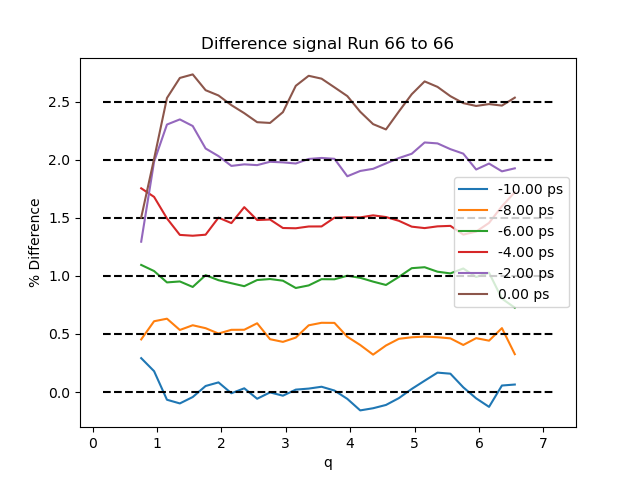

In [32]:
import pandas as pd
s = 0
ds = 0.5
plt.figure()
delay_stage_positions_ps = delay_stage_positions*10**12
for i in range(0, len(delay_stage_positions)):
    y = 100*(scales[i]*time_separated_signal_on[:-2,i] - time_separated_signal_off[:-2,i])/time_separated_signal_off[:-2,i]
    #plt.plot(qbins[:-3], 100*y, label = '%03f ps' % delay_stage_positions_ps[i])
    plt.plot(qbins[:-3], pd.Series(y).rolling(window=3).mean()+s, label='%1.2f ps' %delay_stage_positions_ps[i])
    baseline = np.repeat(s,np.size(qbins))
    plt.plot(qbins,baseline,'--k')
    s+=ds
plt.xlabel('q')
plt.ylabel('% Difference')
#}plt.legend(loc=(1,0.5))
plt.legend()
#plt.xlim(0,16)
#plt.ylim(-0.4,0.8)
plt.title('Difference signal Run %d to %d' % (runNumbers[0], runNumbers[len(runNumbers) - 1]))
#plt.show()
plt.savefig('run%d_Lineplot.png' % runNumbers[0])

## Overlapped Line Plots

/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/h5-1.0.0/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


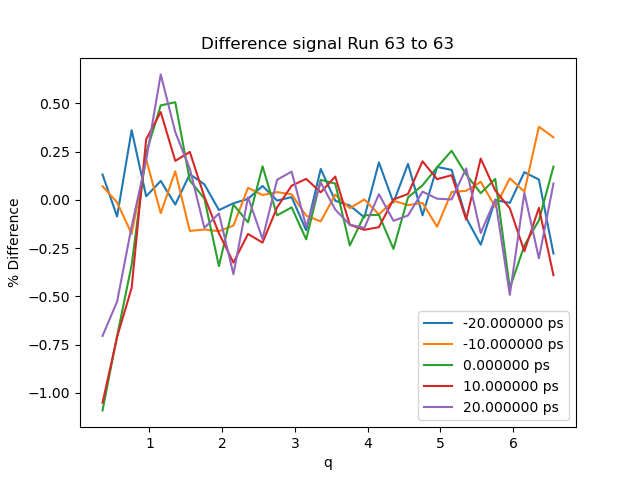

In [10]:
plt.figure()
delay_stage_positions_ps = delay_stage_positions*10**12
for i in range(0, len(delay_stage_positions)):
    plt.plot(qbins[:-3], 100*(scales[i]*time_separated_signal_on[:-2,i] - time_separated_signal_off[:-2,i])/time_separated_signal_off[:-2,i], label = '%03f ps' % delay_stage_positions_ps[i])
plt.xlabel('q')
plt.ylabel('% Difference')
plt.legend()
#plt.xlim(0,16)
#plt.ylim(-0.4,0.8)
plt.title('Difference signal Run %d to %d' % (runNumbers[0], runNumbers[len(runNumbers) - 1]))
plt.show()
#plt.savefig('Difference_Signal_%d_%d.png' % (runNumbers[0], runNumbers[len(runNumbers) - 1]))